In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
from src.visualization.vis_data import *
from src.models.predict_model import * 
import seaborn as sns

output_notebook()
plt.rcParams.update({'font.size': 14})
color_list = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

Loading BokehJS ...

# Explore Data 

In [2]:
# start building dataset from scratch only perform this when new data files are added 
dataset = Dataset('Nakhon Ratchasima')
dataset.build_all_data( build_fire=True, build_holiday=True)

th_stations ['47t']
Averaging data from 2 stations


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

Loading all hotspots data. This might take sometimes


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:41<00:00,  1.37s/it]


before drop (3481265, 20)
after drop (3429841, 12)


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.05s/it]


before drop (3481265, 20)
after drop (3429841, 12)
Getting holiday for  thailand


In [3]:
# reinit the data and load saved process data 
dataset = Dataset('Nakhon Ratchasima')
dataset.load_()
# merge pollution data with other data except fire
dataset.feature_no_fire()

pollutants to plot Index(['PM2.5', 'PM10', 'O3', 'CO', 'NO2', 'SO2'], dtype='object')


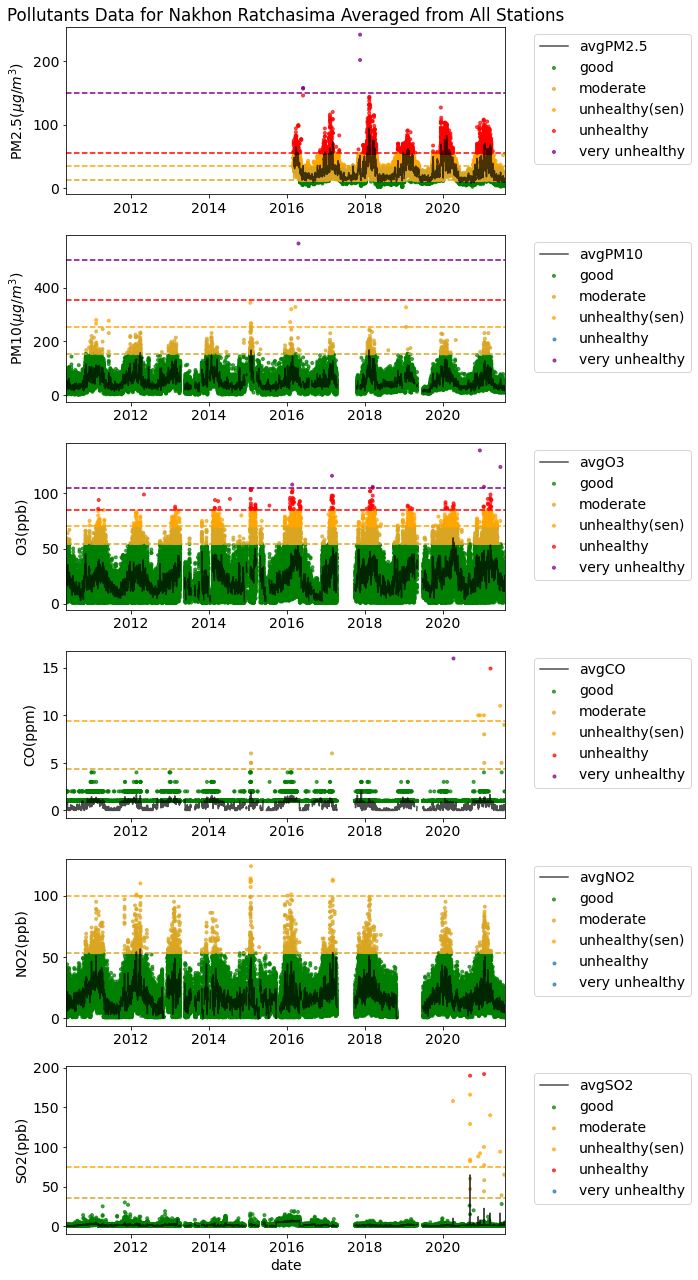

In [4]:
# plot the raw data
plot_all_pollutions(dataset.poll_df, city_name=dataset.city_name)

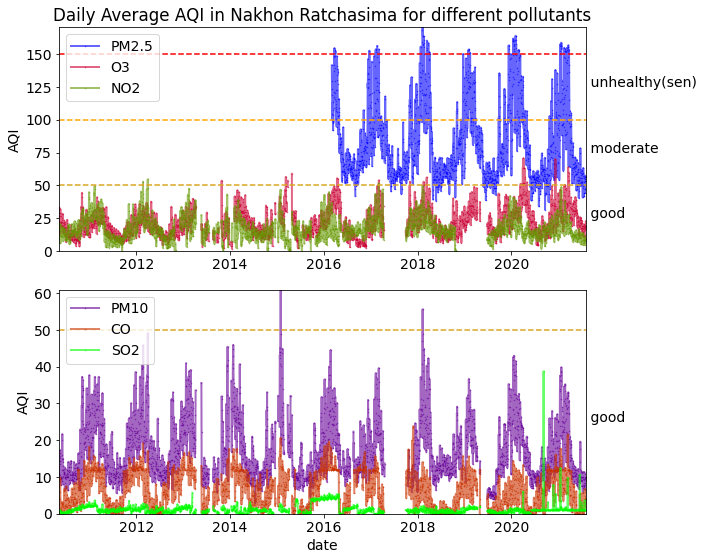

In [5]:
plot_polls_aqi(dataset.poll_df.copy(), dataset.roll_dict, dataset.city_name, filename=dataset.report_folder + 'all_pol_aqi.png' )

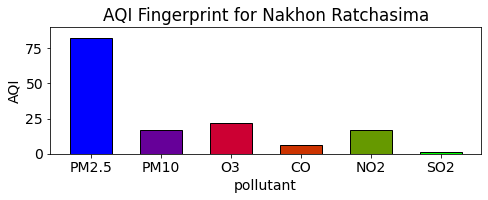

In [6]:
plot_chem_print(poll_to_aqi(dataset.poll_df.copy(), dataset.roll_dict).mean(axis=0), dataset.city_name, filename=dataset.report_folder + 'fingerprint.png')

aqi 100 in  Nov-04 to Apr-15
aqi 150 in  Feb-08 to Feb-09


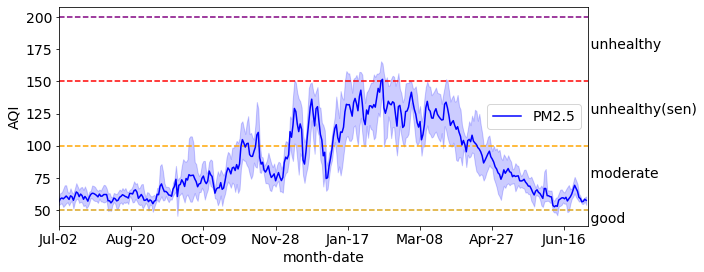

In [7]:
ax, winter_day_dict = plot_season_aqi(dataset.poll_df.copy(), dataset.roll_dict, 'PM2.5', filename=dataset.report_folder + 'seasonal_pattern_PM25.png')

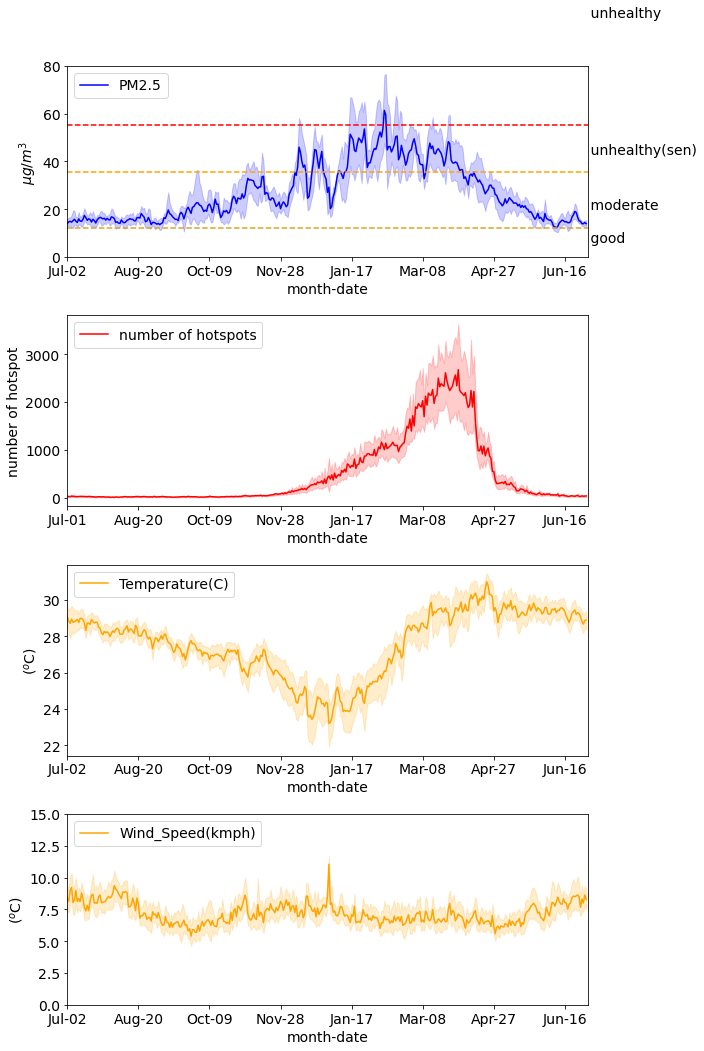

In [8]:
ax = compare_seson_avg(dataset, agg='mean')
ax[0].set_ylim([0, 80])
ax[3].set_ylim([0,15])

plt.savefig(dataset.report_folder + 'fire_PM25_season.png')

ValueError: too many values to unpack (expected 2)

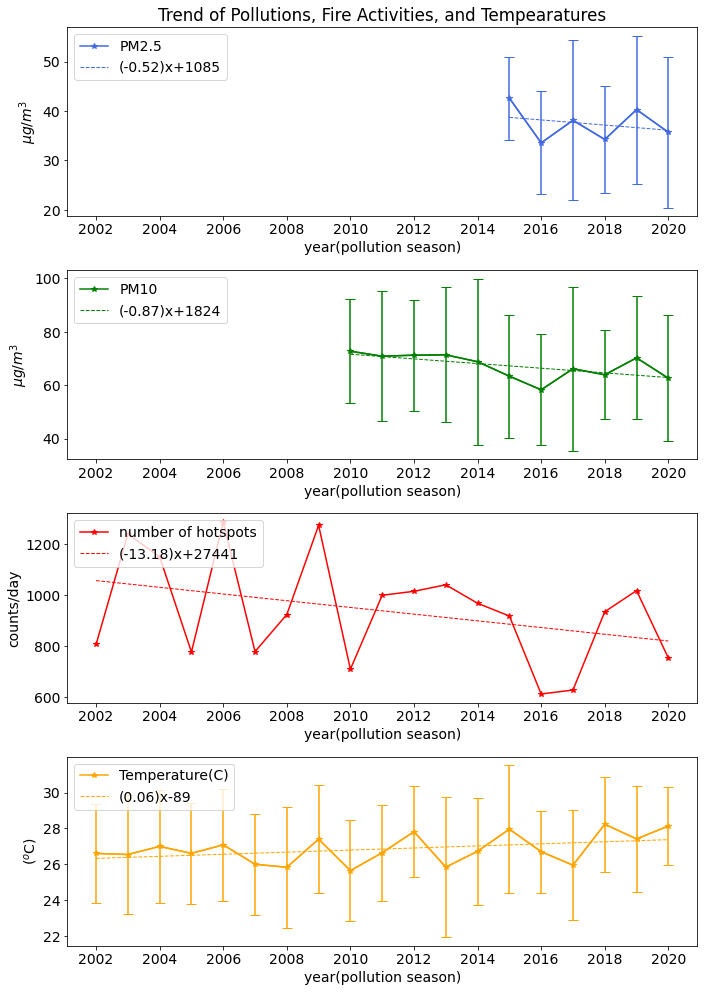

In [9]:
ax, year_avg = plot_yearly_ln(dataset, start_month='-11-01', end_month='-04-30', filename=dataset.report_folder + 'compare_ln_trends.png')

# Fire Zone

In the picture below, I divided the hotspots into 4 zones. The inner fire zone (130km) is within Thailand. The majority of the area is within Korat because it is a big province. The 130-300km zone cover most of the burning in Thailand and part of Cambodia, which is near Thailand boarder. The 300 - 600km km zone include the fire activities in Cambodia with peak burning in December, and Laos with peak burning in March. The outer most zone (600 - 1200km), blue include the burning activities in Myanmar with most burning in March. 

There are two types of crops with burning activities are: sugar cane and maize. The sugar cane crops are local to the north eastern and lower north of Thailand. The maize crops are in the north part of Thailand. These two crops have slightly different burning patterns. Although we cannot tell them apart using just the hotpots data. It different burning densities in December and March highly suggest two types of crops.  

In [17]:
# data to plot in excel
plot_data_list = []
city_x = merc_x(dataset.city_info['Longitude'])
city_y = merc_y(dataset.city_info['Latitude'])

stepx = 800E3
stepy = stepx

fire = dataset.fire

# range bounds supplied in web mercator coordinates
p = figure(x_range=(city_x-0.9*stepx,city_x+1.1*stepx), y_range=(city_y-stepy*0.5, city_y+stepy*0.0001),
           x_axis_type="mercator", y_axis_type="mercator",
          title = 'Fire Zone')

p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))


p.circle(city_x, city_y,color='black',line_color='black',size=5, legend_label=dataset.city_info['City'])

i = 0
month_list = ['2019-03','2019-04']
month = month_list[i]
print(month)
color = 'red'
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='red',size=1, alpha=0.5,legend_label='fire in Mar 2019')
plot_data_list.append(data)


month_list = ['2018-12','2019-01']
month = month_list[i]
print(month)
data = fire.loc[month:month_list[i+1]]
p.scatter(data['long_km']*1000,data['lat_km']*1000,color='blue',size=1, alpha=0.5, legend_label='fire in Dec 2018')
plot_data_list.append(data)


rs = [130, 300, 600, 1200]
labels = [f'{a}_{b}km' for a, b in zip(([0] + rs), rs)]
rs.reverse()
labels.reverse()
colors = get_color(color_length=len(labels),cmap=cm.jet)

for i, (r, label, color) in enumerate(zip(rs, labels, colors)):
    alpha=0.2
        
    xy = get_circle(city_x, city_y,r=r*1E3)
    plot_data_list.append(pd.DataFrame(xy.transpose(),columns=['x','y']))
    p.patch(xy[0,:],xy[1,:],alpha=alpha,line_width=2,color=color, legend_label=label)
    p.line(xy[0,:],xy[1,:],alpha=alpha,line_width=3,line_color=color)
    
show(p)
export_png(p, filename=dataset.report_folder + "fire_zone.png")

2019-03
2018-12


'C:\\Users\\Benny\\Documents\\Fern\\aqi_thailand2\\reports\\nakhon_ratchasima\\fire_zone.png'

# Train Model

## PM2.5

In [10]:
dataset = Dataset('Nakhon Ratchasima')

=================find the best RF model=================
best rf score  0.22088959672548808
val score after op_rf {'val_r2_score': 0.5707, 'val_r2': 0.694, 'val_mean_squared_error': 130.0427, 'val_mean_absolute_error': 8.579, 'val_mean_absolute_percentage_error': 43.267, 'val_median_absolute_error': 5.9901}
test score after op_rf {'test_r2_score': 0.4883, 'test_r2': 0.7058, 'test_mean_squared_error': 168.0119, 'test_mean_absolute_error': 9.6958, 'test_mean_absolute_percentage_error': 45.7711, 'test_median_absolute_error': 7.3767}
================ remove unncessary columns no lag=================


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:30<00:00,  3.02s/it]


score after dropping columns  {'r2_score': 0.5707, 'r2': 0.694, 'mean_squared_error': 130.0427, 'mean_absolute_error': 8.579, 'mean_absolute_percentage_error': 43.267, 'median_absolute_error': 5.9901}
export figure as  C:/Users/Benny/Documents/Fern/aqi_thailand2/reports/nakhon_ratchasima/_PM25_rf_fea_op2.png
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 20 mins
new fire parameter {'w_speed': 15.9, 'shift': -31, 'roll': 178, 'damp_surface': 4.9, 'wind_damp': 0, 'wind_lag': 1, 'split_direct': 0} give score = 106.17142137090742
op fire give val score {'val_r2_score': 0.5928, 'val_r2': 0.7061, 'val_mean_squared_error': 113.7165, 'val_mean_absolute_error': 8.264, 'val_mean_absolute_percentage_error': 39.8053, 'val_median_absolute_error': 6.0483}
op fire give test score {'test_r2_score': 0.4854, 'test_r2': 0.6975, 'test_mean_squared_error': 174.6943, 'test_mean_absolute_error': 9.7022, 'test_mean_absolut

100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [06:04<00:00,  4.29s/it]


score after dropping columns  {'r2_score': 0.656, 'r2': 0.7507, 'mean_squared_error': 96.1073, 'mean_absolute_error': 7.6505, 'mean_absolute_percentage_error': 37.8179, 'median_absolute_error': 5.7712}
best rf score  0.48319318509907533
val score after op6 {'val_r2_score': 0.6419, 'val_r2': 0.7454, 'val_mean_squared_error': 100.0551, 'val_mean_absolute_error': 7.8065, 'val_mean_absolute_percentage_error': 37.4706, 'val_median_absolute_error': 5.7486}
test score after op6  {'testop6_r2_score': 0.5135, 'testop6_r2': 0.7304, 'testop6_mean_squared_error': 165.1935, 'testop6_mean_absolute_error': 9.206, 'testop6_mean_absolute_percentage_error': 39.5005, 'testop6_median_absolute_error': 6.6333}
final score for test set {'test_r2_score': 0.5104, 'test_r2': 0.7415, 'test_mean_squared_error': 166.2219, 'test_mean_absolute_error': 9.0412, 'test_mean_absolute_percentage_error': 37.0341, 'test_median_absolute_error': 6.3006}
daily avg score for test set {'avg_test_r2_score': 0.6064, 'avg_test_r2':

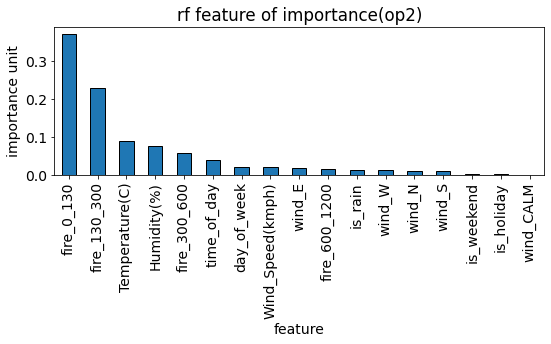

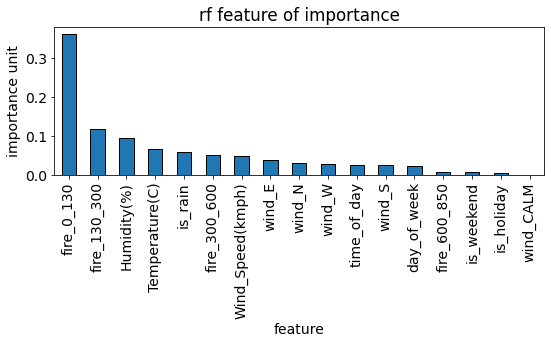

In [11]:
%%time
filename = dataset.model_folder + 'PM25_model_meta.json'
model_meta = load_meta(filename)
model_meta['rolling'] = 1
model_meta['cat_hour'] = 0
model_meta['cat_month'] = 0
#model_meta['zone_list'] =  [0, 100, 200, 400, 600, 800, 1000]
save_meta(filename, model_meta)
# training 1 hour avg center
dataset, model, trainer = train_city_s1(city='Nakhon Ratchasima', pollutant= 'PM2.5', instr='MODIS', add_weight=True, op_fire_zone=True, op_lag=True, choose_cat_hour=False, choose_cat_month=False)

raw model performance {'test_r2_score': 0.5099, 'test_r2': 0.7413, 'test_mean_squared_error': 165.9441, 'test_mean_absolute_error': 9.0185, 'test_mean_absolute_percentage_error': 36.9605, 'test_median_absolute_error': 6.2478}
daily avg training error {'avg_trn_r2_score': 0.9981, 'avg_trn_r2': 0.9992, 'avg_trn_mean_squared_error': 0.3187, 'avg_trn_mean_absolute_error': 0.405, 'avg_trn_mean_absolute_percentage_error': 1.5849, 'avg_trn_median_absolute_error': 0.2853}
daily avg test error {'avg_test_r2_score': 0.6064, 'avg_test_r2': 0.81, 'avg_test_mean_squared_error': 108.0685, 'avg_test_mean_absolute_error': 7.4151, 'avg_test_mean_absolute_percentage_error': 27.3562, 'avg_test_median_absolute_error': 4.992}


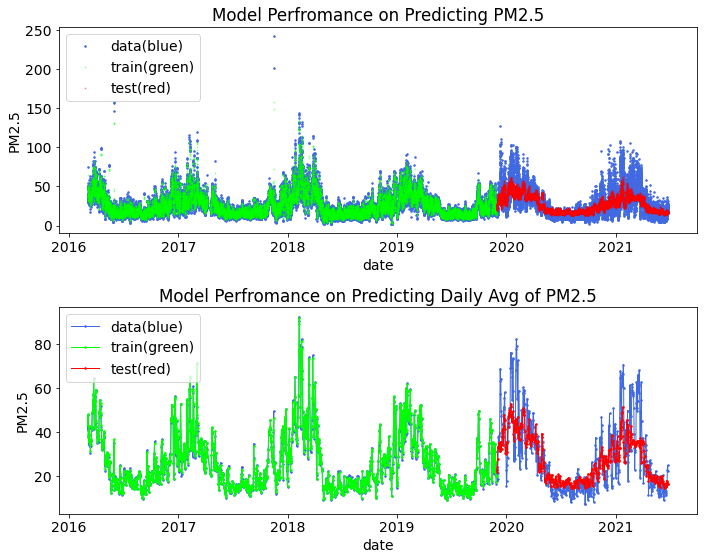

In [12]:
dataset, model, fire_cols, zone_list, feat_imp, rolling_win = load_model(city='Nakhon Ratchasima', pollutant='PM2.5' )
_, df = plot_model_perf(dataset=dataset, model= model, split_list=model_meta['split_lists'][-1], xlim=[], to_save=True)

Model performance vs seasonal pattern and residue

In [13]:
# calculate the average error for the test data
ytest_pred_df = cal_error(dataset, model, data_index=dataset.split_list[1])
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()

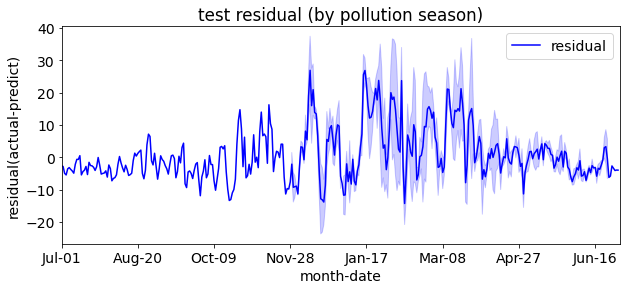

In [14]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(ytest_pred_df, 'residual', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('test residual (by pollution season)')
ax.set_ylabel('residual(actual-predict)')
plt.savefig(dataset.report_folder + 'PM25_season_residual.png', dpi=300 )

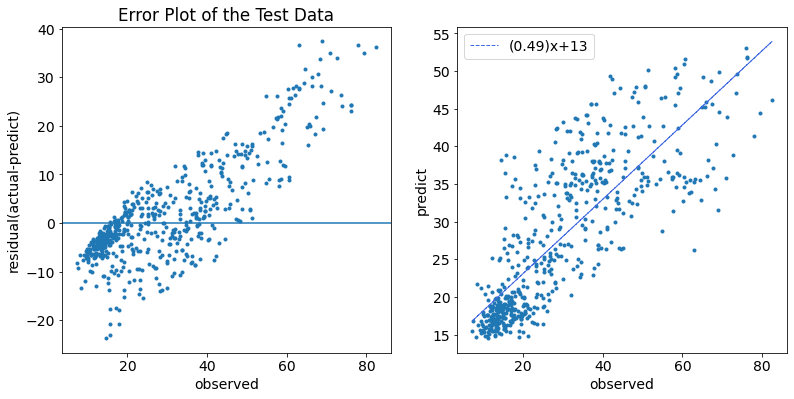

In [15]:
# plot residual vs actual value
_, ax = plt.subplots(1,2, figsize=(13, 6))

ax[0].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['residual'], marker='.')
ax[0].set_ylabel('residual(actual-predict)')
ax[0].set_xlabel('observed')
ax[0].axhline(0)
ax[0].set_title('Error Plot of the Test Data')

ax[1].scatter(ytest_pred_df_avg['actual'], ytest_pred_df_avg['pred'], marker='.')
ax[1].set_ylabel('predict')
ax[1].set_xlabel('observed')
#ax[1].set_title('Error Plot of the Test Data')
s = ytest_pred_df_avg['pred']
s.index = ytest_pred_df_avg['actual']
add_ln_trend_line(s, ax=ax[1])
ax[1].legend()
plt.savefig(dataset.report_folder + 'PM25_residual.png', dpi=300 )

## PM2.5 (2)

=================find the best RF model=================
best rf score  -0.060645411100529165
val score after op_rf {'val_r2_score': 0.5741, 'val_r2': 0.6995, 'val_mean_squared_error': 144.6828, 'val_mean_absolute_error': 9.1118, 'val_mean_absolute_percentage_error': 48.9678, 'val_median_absolute_error': 6.3472}
test score after op_rf {'test_r2_score': 0.4393, 'test_r2': 0.6637, 'test_mean_squared_error': 192.2453, 'test_mean_absolute_error': 9.9412, 'test_mean_absolute_percentage_error': 38.4998, 'test_median_absolute_error': 7.0327}
================ remove unncessary columns no lag=================


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.53s/it]


score after dropping columns  {'r2_score': 0.5845, 'r2': 0.7091, 'mean_squared_error': 141.1384, 'mean_absolute_error': 9.013, 'mean_absolute_percentage_error': 48.3269, 'median_absolute_error': 6.3139}
================= find the best fire feature ===================
optimizing fire parameter using skopt optimizer. This will take about 4 hours
old fire parameter {'w_speed': 2.0, 'shift': 39, 'roll': 154, 'damp_surface': 4.9, 'wind_damp': False, 'wind_lag': True, 'split_direct': 0} is still better than optimized score =139.68848701968915
op fire give val score {'val_r2_score': 0.6102, 'val_r2': 0.7197, 'val_mean_squared_error': 109.0247, 'val_mean_absolute_error': 7.9694, 'val_mean_absolute_percentage_error': 41.4518, 'val_median_absolute_error': 5.5348}
op fire give test score {'test_r2_score': 0.4404, 'test_r2': 0.6671, 'test_mean_squared_error': 191.8707, 'test_mean_absolute_error': 9.8765, 'test_mean_absolute_percentage_error': 37.4927, 'test_median_absolute_error': 6.8948}
old scor

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [04:01<00:00,  3.55s/it]


score after dropping columns  {'r2_score': 0.6513, 'r2': 0.746, 'mean_squared_error': 99.7657, 'mean_absolute_error': 7.6686, 'mean_absolute_percentage_error': 38.9562, 'median_absolute_error': 5.2821}
best rf score  0.26793081819679376
val score after op6 {'val_r2_score': 0.6489, 'val_r2': 0.7477, 'val_mean_squared_error': 100.463, 'val_mean_absolute_error': 7.6973, 'val_mean_absolute_percentage_error': 39.5994, 'val_median_absolute_error': 5.2654}
test score after op6  {'testop6_r2_score': 0.4499, 'testop6_r2': 0.6744, 'testop6_mean_squared_error': 187.9741, 'testop6_mean_absolute_error': 9.7756, 'testop6_mean_absolute_percentage_error': 37.561, 'testop6_median_absolute_error': 6.9795}
final score for test set {'test_r2_score': 0.4491, 'test_r2': 0.6828, 'test_mean_squared_error': 188.2338, 'test_mean_absolute_error': 9.5813, 'test_mean_absolute_percentage_error': 35.326, 'test_median_absolute_error': 6.5604}
daily avg score for test set {'avg_test_r2_score': 0.5516, 'avg_test_r2': 0

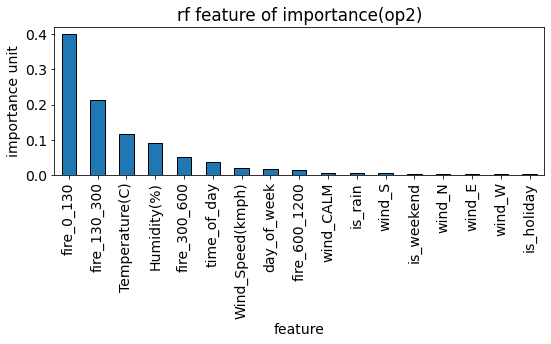

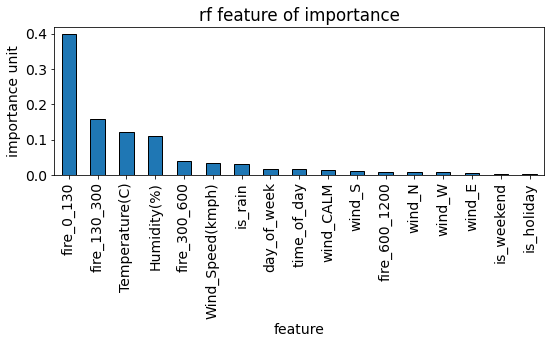

In [7]:
%%time
dataset, model, trainer = train_city_s1(city='Nakhon Ratchasima', pollutant= 'PM2.5', search_wind_damp=True, choose_cat_hour=True, choose_cat_month=False, op_lag=True )

raw model performance {'test_r2_score': 0.4545, 'test_r2': 0.6872, 'test_mean_squared_error': 186.1383, 'test_mean_absolute_error': 9.5228, 'test_mean_absolute_percentage_error': 35.1179, 'test_median_absolute_error': 6.5259}
daily avg training error {'avg_trn_r2_score': 0.873, 'avg_trn_r2': 0.9393, 'avg_trn_mean_squared_error': 22.5091, 'avg_trn_mean_absolute_error': 3.5127, 'avg_trn_mean_absolute_percentage_error': 14.8871, 'avg_trn_median_absolute_error': 2.5821}
daily avg test error {'avg_test_r2_score': 0.5588, 'avg_test_r2': 0.7625, 'avg_test_mean_squared_error': 117.4429, 'avg_test_mean_absolute_error': 7.8281, 'avg_test_mean_absolute_percentage_error': 26.3193, 'avg_test_median_absolute_error': 5.2228}


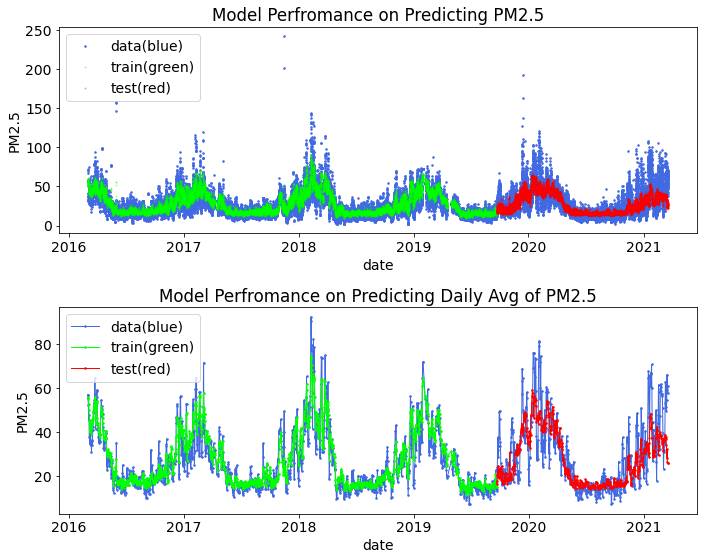

In [8]:
dataset, model, fire_cols, zone_list, feat_imp, rolling_win = load_model(city='Nakhon Ratchasima', pollutant='PM2.5' )
_, df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [9]:
# read model feature of importance after training 
feat_imp = pd.read_csv(dataset.model_folder + 'PM25_final_featimp.csv')
# add label related to different factors 
for i, row in feat_imp.iterrows():
    if 'fire' in row['index']:
        feat_imp.loc[i, 'source'] = 'agricultural\nburning'
        
    elif row['index'] in ['Humidity(%)', 'Temperature(C)', 'Wind_Speed(kmph)', 'is_rain']:
        feat_imp.loc[i, 'source'] = 'local weather'
    elif row['index'] in ['time_of_day', 'is_holiday']:
        feat_imp.loc[i, 'source'] = 'traffic'
    elif 'wind_' in row['index']:
        feat_imp.loc[i, 'source'] = 'other sources\nex industry'
        
# summing contribution from different source 
source_contri = feat_imp.groupby('source', as_index=False).sum()

In [10]:
# convert to degress
# normalize 
source_contri['importance'] /= source_contri['importance'].sum() 
source_contri['importance'] = source_contri['importance'].round(2)
source_contri['degree'] = source_contri['importance']*360 
source_contri['degree'] = source_contri['degree'].astype(int)
source_contri['importance'] *= 100 

In [11]:
source_contri

source  importance  degree
0       agricultural\nburning        62.0     223
1               local weather        30.0     108
2  other sources\nex industry         5.0      18
3                     traffic         2.0       7

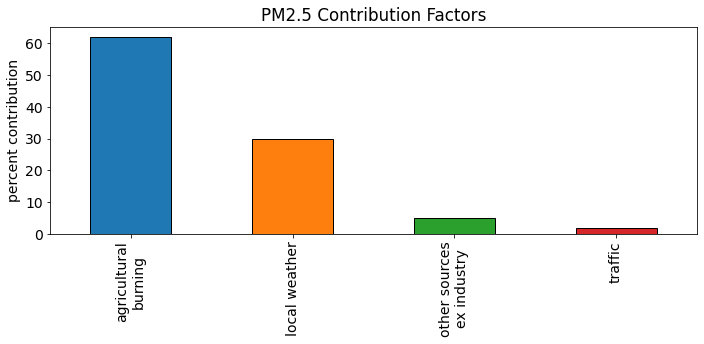

In [13]:
source_contri.plot('source',
            'importance',
            kind='bar', color=[ u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728' ],
            figsize=(
                10,
                5),
            linewidth=1,
            edgecolor='black',
            legend=False, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))

plt.ylabel('percent contribution')
plt.xlabel(None)
plt.title('PM2.5 Contribution Factors')
plt.tight_layout()

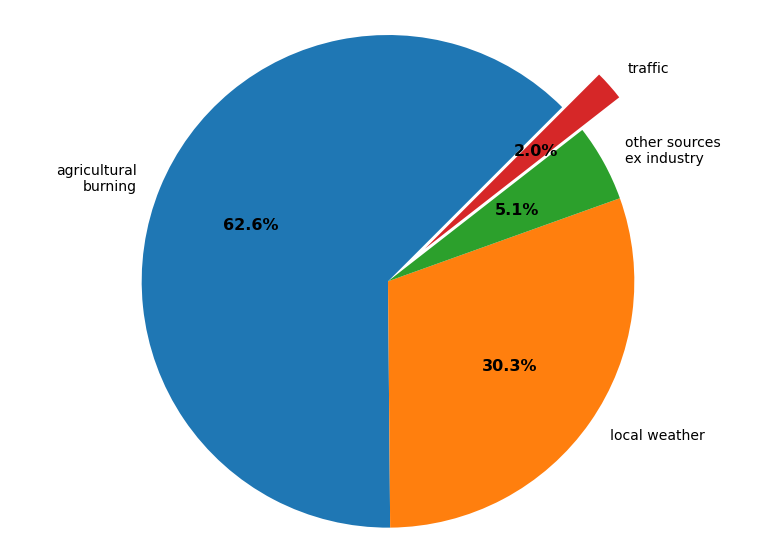

In [16]:
fig, ax = plt.subplots(1,1, figsize=(11,8))

explode = (0, 0, 0.0, 0.2)
wedges, texts, autotexts = ax.pie(source_contri['degree'], autopct='%1.1f%%', labels = source_contri['source'].tolist(),explode= explode, shadow=False, startangle=45)
ax.axis('equal')
   

# = ax.pie(data, autopct=lambda pct: func(pct, data),
#                                  textprops=dict(color="w"))

labels = [ str(round(p*100/360, 1)) +'%' + ' '+s   for s, p in zip(source_contri['source'], source_contri['degree'])]

#ax.legend(wedges, labels,
#          title="factors",
#          loc="upper right", bbox_to_anchor=(1.3, 0.9))

plt.setp(autotexts, size=16, weight="bold")
plt.tight_layout()
plt.savefig(dataset.report_folder + 'PM25_feat_imp_pie.png')

In [17]:
# summing contribution from different source 
source_contri = feat_imp.groupby('source', as_index=False).sum()
# remove weather 
source_contri = source_contri[source_contri['source'] != 'local weather']
# convert to degress
# normalize 
source_contri['importance'] /= source_contri['importance'].sum() 
source_contri['importance'] = source_contri['importance'].round(2)

source_contri['degree'] = source_contri['importance']*360 
source_contri['degree'] = source_contri['degree'].astype(int)

source_contri['importance'] *= 100 
source_contri

source  importance  degree
0       agricultural\nburning        89.0     320
2  other sources\nex industry         8.0      28
3                     traffic         3.0      10

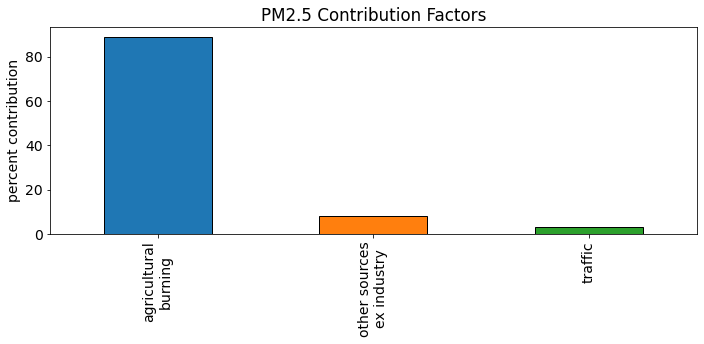

In [18]:
source_contri.plot('source',
            'importance',
            kind='bar', color=[ u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728' ],
            figsize=(
                10,
                5),
            linewidth=1,
            edgecolor='black',
            legend=False, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))

plt.ylabel('percent contribution')
plt.xlabel(None)
plt.title('PM2.5 Contribution Factors')
plt.tight_layout()

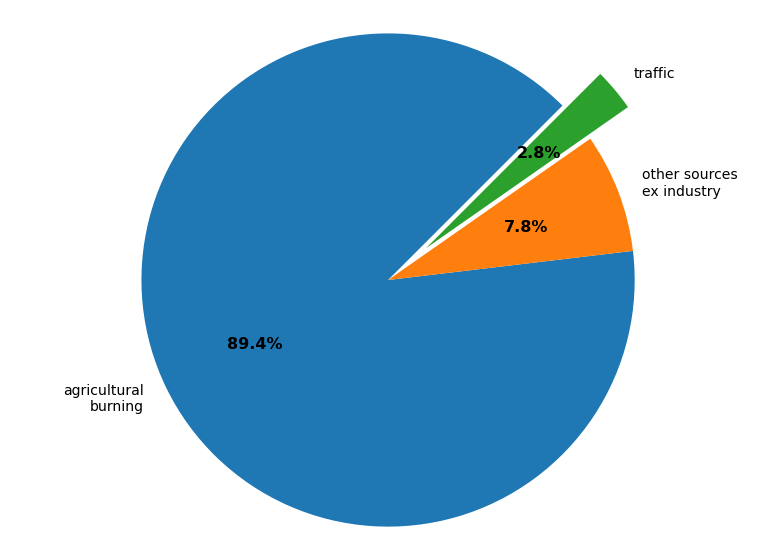

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11,8))

explode = (0, 0, 0.2 )
wedges, texts, autotexts = ax.pie(source_contri['degree'], autopct='%1.1f%%', labels = source_contri['source'].tolist(),explode= explode, shadow=False, startangle=45)
ax.axis('equal')
   

# = ax.pie(data, autopct=lambda pct: func(pct, data),
#                                  textprops=dict(color="w"))

labels = [ str(round(p*100/360, 1)) +'%' + ' '+s   for s, p in zip(source_contri['source'], source_contri['degree'])]

#ax.legend(wedges, labels,
#          title="factors",
#          loc="upper right", bbox_to_anchor=(1.3, 0.9))

plt.setp(autotexts, size=16, weight="bold")
plt.tight_layout()

# Inferer Object

In [21]:
# init Inferer
inferer = Inferer(city_name='Nakhon Ratchasima', pollutant='PM2.5')
# a dataset object if one of Inferer's attributes
dataset = inferer.dataset

raw model performance {'test_r2_score': 0.4545, 'test_r2': 0.6872, 'test_mean_squared_error': 186.1383, 'test_mean_absolute_error': 9.5228, 'test_mean_absolute_percentage_error': 35.1179, 'test_median_absolute_error': 6.5259}
daily avg training error {'avg_trn_r2_score': 0.873, 'avg_trn_r2': 0.9393, 'avg_trn_mean_squared_error': 22.5091, 'avg_trn_mean_absolute_error': 3.5127, 'avg_trn_mean_absolute_percentage_error': 14.8871, 'avg_trn_median_absolute_error': 2.5821}
daily avg test error {'avg_test_r2_score': 0.5588, 'avg_test_r2': 0.7625, 'avg_test_mean_squared_error': 117.4429, 'avg_test_mean_absolute_error': 7.8281, 'avg_test_mean_absolute_percentage_error': 26.3193, 'avg_test_median_absolute_error': 5.2228}
max error 9.384680350344523


In [22]:
inferer.get_data_sample_(n_samples=20, step=1, day_err=10, hour_err=2)

  0%|                                                                                                                             | 0/13060 [00:00<?, ?it/s]

obtaining inference samples. This will take about 15 mins


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13060/13060 [02:33<00:00, 85.16it/s]


datasample columns Index(['Humidity(%)', 'Humidity(%)_lag_1', 'Humidity(%)_lag_13',
       'Humidity(%)_lag_7', 'Temperature(C)', 'Temperature(C)_lag_1',
       'Temperature(C)_lag_13', 'Temperature(C)_lag_7', 'Wind_Speed(kmph)',
       'Wind_Speed(kmph)_lag_1', 'Wind_Speed(kmph)_lag_13',
       'Wind_Speed(kmph)_lag_7', 'is_rain', 'is_rain_lag_1', 'is_rain_lag_13',
       'is_rain_lag_7', 'wind_CALM', 'wind_CALM_lag_1', 'wind_CALM_lag_13',
       'wind_CALM_lag_7', 'wind_E', 'wind_E_lag_1', 'wind_E_lag_13',
       'wind_E_lag_7', 'wind_N', 'wind_N_lag_1', 'wind_N_lag_13',
       'wind_N_lag_7', 'wind_S', 'wind_S_lag_1', 'wind_S_lag_13',
       'wind_S_lag_7', 'wind_W', 'wind_W_lag_1', 'wind_W_lag_13',
       'wind_W_lag_7', 'datetime', 'fire_0_130', 'fire_130_300',
       'fire_300_600', 'fire_600_1200', 'fire_0_130_lag_1',
       'fire_130_300_lag_1', 'fire_300_600_lag_1', 'fire_600_1200_lag_1',
       'fire_0_130_lag_7', 'fire_130_300_lag_7', 'fire_300_600_lag_7',
       'fire_600_1

(0.0, 85.0)

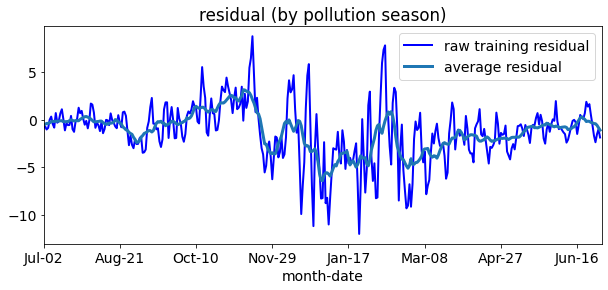

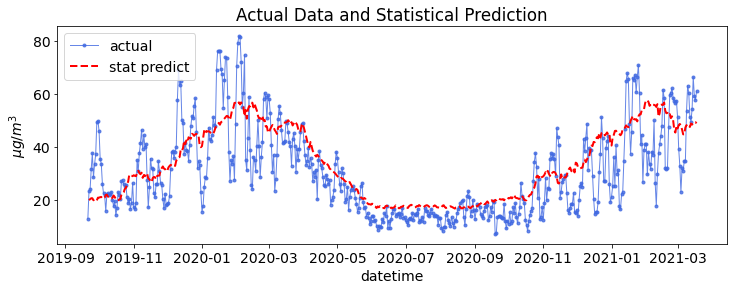

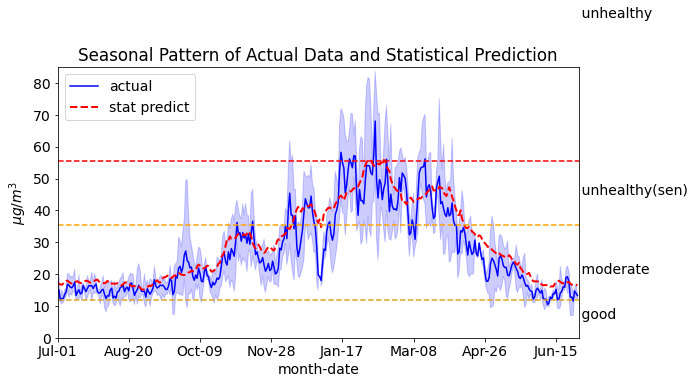

In [32]:
ax, sea_pred = inferer.compare_inf_act(q_list=[ 0.8])
ax.set_ylim([0, 85])

In [33]:
# yearly average
sea_pred.mean(axis=0)

q0.8    29.826946
dtype: float64

In [34]:
# winter average
sea_pred.loc[winter_days].mean()

q0.8    42.316232
dtype: float64

In [25]:
df, winter_day_dict = season_avg(inferer.dataset.poll_df, cols=['PM2.5'], roll=True, agg='max', offset=182)
mean_day = df.groupby('winter_day').mean()['PM2.5']
mean_day.mean()

29.77875613156297

In [26]:
winter_days = np.arange(154, 306)

In [27]:
mean_day.loc[winter_days].mean()

42.52932657163743

# Effect of Reduce Fire

5

In [40]:
features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,len(zone_list)):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
rawplot_folder = dataset.model_folder
fea_effect_3m = inferer.features_effect_sum(feature_list, q=0.80, red_list=[0,  0.9999 ], time_range=[124, 276],agg='mean', raw_filename= rawplot_folder +'effect_of_fire_reduction_3m' )
fea_effect_3m.columns = columns_list
# change from percent to whole number
fea_effect_3m.index *= 100
fea_effect_3m.index = fea_effect_3m.index.astype(int)
# save the raw plot for animation 
fea_effect_3m.to_csv(dataset.model_folder +'effect_of_fire_reduction_3m.csv', index=True)

In [41]:
fea_effect_3m

fire 0-130km  fire 0-300km  fire 0-600km  fire 0-1200km
100     41.421683     41.421683     41.421683      41.421683
0       30.319069     29.185303     29.029469      29.031295

In [42]:
fire_season = pd.read_csv(rawplot_folder +'effect_of_fire_reduction_3m_3.csv').set_index('winter_day')

In [43]:
# calculate the mean of BKK 
winter_days = np.arange(154, 306)
df, winter_day_dict = season_avg(inferer.dataset.poll_df, cols=['PM2.5'], roll=True, agg='max', offset=182)
mean_day = df.groupby('winter_day').mean()['PM2.5']
yl_mean = mean_day.mean()
win_mean = mean_day.loc[winter_days].mean()

print(yl_mean, win_mean)

29.77875613156297 42.52932657163743


In [44]:
yl_mean = fire_season.mean(axis=0).iloc[0]
win_mean = fire_season.loc[winter_days].mean(axis=0).iloc[0]

print(yl_mean, win_mean)

29.82694573481981 42.31623200211968


In [45]:
# yearly differences 
agri_yl = yl_mean - fire_season.mean(axis=0).iloc[1]

In [46]:
# winter differences 

agri_win = win_mean - fire_season.loc[winter_days].mean(axis=0).iloc[1]

Effect of traffic

In [47]:
all_cols = inferer.data_samples.columns.to_list()
data_senario = inferer.data_samples.copy()

cols_to_cut = []
features = ['is_holiday', 'is_weekend' ]
for feature in features:
    cols_to_cut  = cols_to_cut + [s for s in all_cols if feature in s ]
data_senario[cols_to_cut]  = 1

#cols_to_cut = []
#features = ['time_of_day' ]
#for feature in features:
#    cols_to_cut  = cols_to_cut + [s for s in all_cols if feature in s ]
#data_senario[cols_to_cut]  = 16.0

cols_to_cut = []
features = ['traffic_index' ]
for feature in features:
    cols_to_cut  = cols_to_cut + [s for s in all_cols if feature in s ]
data_senario[cols_to_cut]  = 0

In [48]:
x = data_senario.values
y = inferer.model.predict(x)

ypred_df = pd.Series(y, index=inferer.data_samples.index)

In [49]:
band_df = make_band(ypred_df, q_list=[0.70])

sea_pred = cal_season_band(band_df, inferer.sea_error)

In [50]:
print(sea_pred.mean())

print(yl_mean - sea_pred.mean()   )
traffic_yl = yl_mean - sea_pred.mean().values[0] 

q0.7    27.385853
dtype: float64
q0.7    2.441093
dtype: float64


In [51]:
print(sea_pred.loc[winter_days].mean())

print(win_mean - sea_pred.loc[winter_days].mean())

traffic_win  = win_mean - sea_pred.loc[winter_days].mean().values[0]

q0.7    37.3171
dtype: float64
q0.7    4.999132
dtype: float64


Other Factor

In [52]:
all_cols = inferer.data_samples.columns.to_list()
data_senario = inferer.data_samples.copy()

features = ['Wind_W', 'Wind_CLAM' , 'Wind_E', 'Wind_N']

cols_to_cut = []

for feature in features:

    cols_to_cut  = cols_to_cut + [s for s in all_cols if feature in s ]
    
data_senario[cols_to_cut]  = 0

features = ['Wind_S' ]
cols_to_cut = []
for feature in features:

    cols_to_cut  = cols_to_cut + [s for s in all_cols if feature in s ]
    
data_senario[cols_to_cut]  = 1

In [53]:
x = data_senario.values
y = inferer.model.predict(x)

ypred_df = pd.Series(y, index=inferer.data_samples.index)
band_df = make_band(ypred_df, q_list=[0.70])

sea_pred = cal_season_band(band_df, inferer.sea_error)

In [54]:
print(sea_pred.mean())

print(yl_mean - sea_pred.mean()   )
oth_yl = yl_mean - sea_pred.mean().values[0]

q0.7    29.906042
dtype: float64
q0.7   -0.079097
dtype: float64


In [55]:
print(sea_pred.loc[winter_days].mean())

print(win_mean - sea_pred.loc[winter_days].mean())

oth_win = win_mean - sea_pred.loc[winter_days].mean().values[0]

q0.7    41.15602
dtype: float64
q0.7    1.160212
dtype: float64


In [56]:
source_contri = pd.DataFrame({'source': ['agricultural\nburning', 'other factors', 'traffic'],
                             'importance_win': [agri_win, oth_win, traffic_win],
                             'importance_yl':[agri_yl , oth_yl  , traffic_yl]})

source_contri['importance_win'] += np.abs(source_contri['importance_win'].min())*2
source_contri['importance_yl'] += np.abs(source_contri['importance_yl'].min())*2

source_contri['importance_win'] /= source_contri['importance_win'].sum() 
source_contri['importance_win'] = source_contri['importance_win'].round(2)
source_contri['degree_win'] = source_contri['importance_win']*360 
source_contri['degree_win'] = source_contri['degree_win'].astype(int)
source_contri['importance_win'] *= 100

source_contri['importance_yl'] /= source_contri['importance_yl'].sum() 
source_contri['importance_yl'] = source_contri['importance_yl'].round(2)
source_contri['importance_yl'] *= 100

source_contri['degree_yl'] = source_contri['importance_yl']*360 
source_contri['degree_yl'] = source_contri['degree_yl'].astype(int)

In [57]:
source_contri

source  importance_win  importance_yl  degree_win  degree_yl
0  agricultural\nburning            60.0           72.0         216      25920
1          other factors            13.0            1.0          46        360
2                traffic            27.0           27.0          97       9720

In [58]:
color_list = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

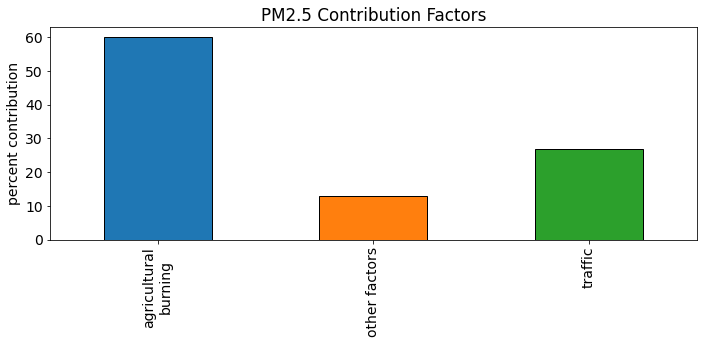

In [59]:
source_contri.plot('source',
            'importance_win',
            kind='bar', color=[ u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728' ],
            figsize=(
                10,
                5),
            linewidth=1,
            edgecolor='black',
            legend=False, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))

plt.ylabel('percent contribution')
plt.xlabel(None)
plt.title('PM2.5 Contribution Factors')
plt.tight_layout()
plt.savefig('E:/Documents/Downloads/' + 'bar_win.png')

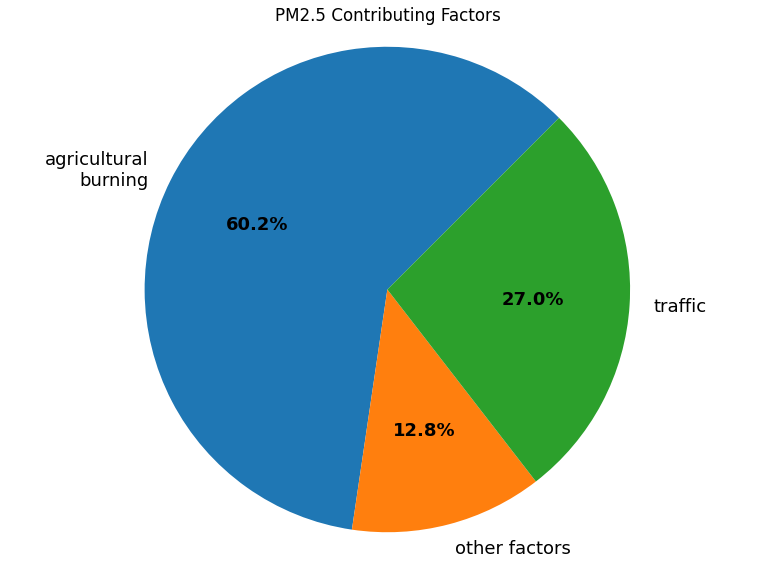

In [60]:
fig, ax = plt.subplots(1,1, figsize=(11,8))

explode = (0, 0, 0.0 )
wedges, texts, autotexts = ax.pie(source_contri['degree_win'], autopct='%1.1f%%', labels = source_contri['source'].tolist(),explode= explode, shadow=False, startangle=45)
ax.axis('equal')
for text in texts:
    text.set_fontsize(18)   

# = ax.pie(data, autopct=lambda pct: func(pct, data),
#                                  textprops=dict(color="w"))

labels = [ str(round(p*100/360, 1)) +'%' + ' '+s   for s, p in zip(source_contri['source'], source_contri['degree_win'])]

#ax.legend(wedges, labels,
#          title="factors",
#          loc="upper right", bbox_to_anchor=(1.3, 0.9))
plt.title('PM2.5 Contributing Factors')
plt.setp(autotexts, size=18, weight="bold")
plt.tight_layout()
plt.savefig('E:/Documents/Downloads/' + 'pie_win.png')

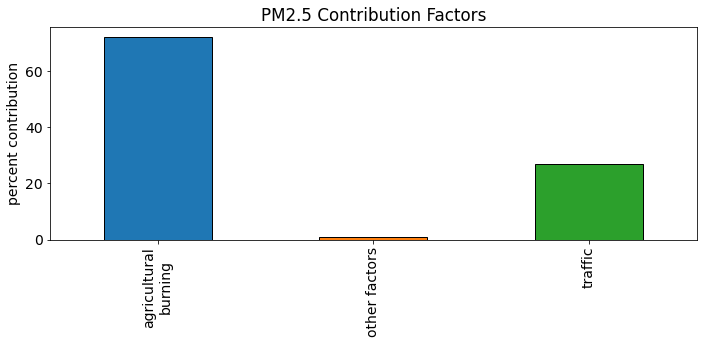

In [61]:
source_contri.plot('source',
            'importance_yl',
            kind='bar', color=[ u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728' ],
            figsize=(
                10,
                5),
            linewidth=1,
            edgecolor='black',
            legend=False, error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1))

plt.ylabel('percent contribution')
plt.xlabel(None)
plt.title('PM2.5 Contribution Factors')
plt.tight_layout()

plt.savefig('E:/Documents/Downloads/' + 'bar_yl.png')

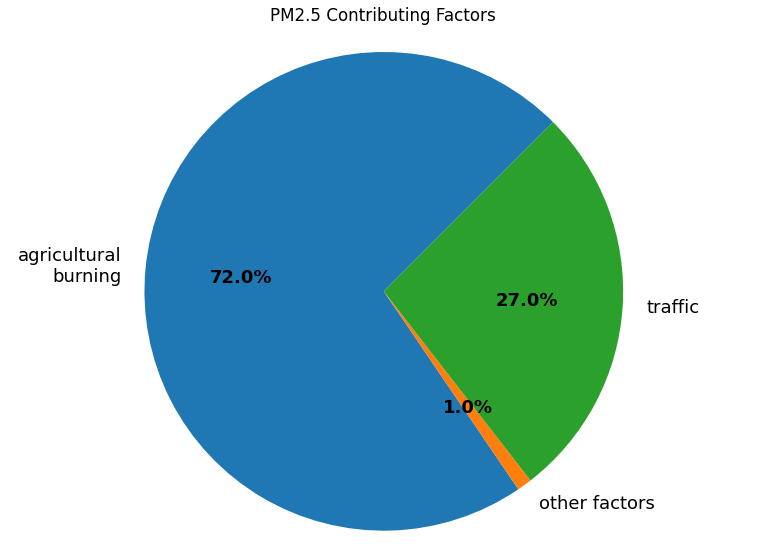

In [62]:
fig, ax = plt.subplots(1,1, figsize=(11,8))

explode = (0, 0, 0.0 )
wedges, texts, autotexts = ax.pie(source_contri['degree_yl'], autopct='%1.1f%%', labels = source_contri['source'].tolist(),explode= explode, shadow=False, startangle=45)
ax.axis('equal')
for text in texts:
    text.set_fontsize(18)   

# = ax.pie(data, autopct=lambda pct: func(pct, data),
#                                  textprops=dict(color="w"))

labels = [ str(round(p*100/360, 1)) +'%' + ' '+s   for s, p in zip(source_contri['source'], source_contri['degree_yl'])]

#ax.legend(wedges, labels,
#          title="factors",
#          loc="upper right", bbox_to_anchor=(1.3, 0.9))
plt.title('PM2.5 Contributing Factors')
plt.setp(autotexts, size=18, weight="bold")
plt.tight_layout()

plt.savefig('E:/Documents/Downloads/' + 'pi_yl.png')